Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
Loss: 0.6987, Accuracy: 53.98%
Validation Loss: 0.8433, Validation Accuracy: 26.90%
Epoch 2/20
Loss: 0.6830, Accuracy: 54.87%
Validation Loss: 0.6915, Validation Accuracy: 32.16%
Epoch 3/20
Loss: 0.6657, Accuracy: 64.60%
Validation Loss: 0.6869, Validation Accuracy: 42.69%
Epoch 4/20
Loss: 0.6271, Accuracy: 65.49%
Validation Loss: 0.6257, Validation Accuracy: 71.35%
Epoch 5/20
Loss: 0.6210, Accuracy: 62.83%
Validation Loss: 0.6406, Validation Accuracy: 68.42%
Epoch 6/20
Loss: 0.5966, Accuracy: 71.68%
Validation Loss: 0.7028, Validation Accuracy: 63.16%
Epoch 7/20
Loss: 0.5384, Accuracy: 70.80%
Validation Loss: 0.7147, Validation Accuracy: 69.01%
Epoch 8/20
Loss: 0.5161, Accuracy: 74.34%
Validation Loss: 0.8123, Validation Accuracy: 64.91%
Epoch 9/20
Loss: 0.4342, Accuracy: 78.76%
Validation Loss: 0.5901, Validation Accuracy: 74.85%
Epoch 10/20
Loss: 0.5081, Accuracy: 74.34%
Validation Loss: 0.7271, Validation Accuracy: 65.50%
Epoch 11/20
Loss: 0.3754, Accuracy: 80.53%
Valida

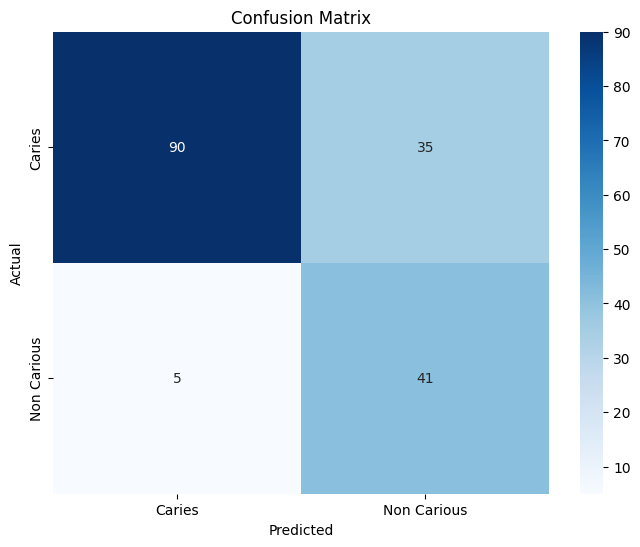

Training complete.


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from transformers import SwinForImageClassification, AutoFeatureExtractor
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set paths
train_dir = r'd:\paper code\gu data\train'
test_dir = r'd:\paper code\gu data\test'

# Image Dataset Class
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.class_names = sorted(os.listdir(data_dir))
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.class_names):
            class_dir = os.path.join(data_dir, class_name)
            for file_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, file_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {image_path}")
            return None, None
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Transformations with Augmentations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# Create Datasets and Loaders
train_dataset = ImageDataset(train_dir, transform=transform)
test_dataset = ImageDataset(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Load Swin Model (with classifier adapted to 2 output classes)
model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224", 
    num_labels=2, 
    ignore_mismatched_sizes=True
)

# Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
epochs = 20

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        if images is None or labels is None:
            continue  # Skip corrupted images
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # Validation Loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            if images is None or labels is None:
                continue  # Skip corrupted images
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    val_loss /= len(test_loader)
    val_acc = 100 * val_correct / val_total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

# Classification Report and Confusion Matrix
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.class_names, yticklabels=train_dataset.class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print("Training complete.")
